# Imports

In [65]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta

import inflection
import math

import seaborn as sns
import matplotlib.pyplot as plt 

from IPython.core.display import HTML
from IPython.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from scipy import stats
from sklearn.feature_selection import RFE
from pycorrcat.pycorrcat import corr_matrix

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

import pickle

#sns.set_theme()

# Funções

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()
    
jupyter_settings()

def cramer_v(x , y):
    
    tabela = pd.crosstab(x, y).values
    n = tabela.sum()
    r,k = tabela.shape
    
    kcorr = k - ((k-1)**2 / (n-1 ))
    rcorr = r - ((r-1)**2 / (n-1 ))
    
    chi2 = stats.chi2_contingency(tabela)[0]
    chi2corr = max(0, chi2 - ( (k-1) * (r-1) / (n-1) ))
    
    return np.sqrt((chi2corr / n) / ( min(kcorr-1, rcorr-1) ))

# Descrição dos dados

Nesta seção, realizamos uma análise inicial dos dados com o objetivo de entender sua natureza e realizar alguns tratamentos necessários. Através dessa análise, podemos criar hipóteses e posteriormente realizar uma análise exploratória melhor.

## Carregando os dados

Importando os dados de treino com dados de venda

In [3]:
df_sales = pd.read_csv('data/train.csv', low_memory = False)
df_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Importando dados das lojas

In [4]:
df_store = pd.read_csv('data/store.csv', low_memory = False)
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
df_raw = pd.merge(df_sales, df_store, how = 'left', on = 'Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Renomeando Colunas

In [6]:
df1 = df_raw.copy()

In [7]:
# usando a função underscore do módulo inflection deixando todas as primeiras letras das palavas em minúsculo
cols_pre = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval'] 

snakecase = lambda x: inflection.underscore(x) 

cols_new = list(map(snakecase, cols_pre))
df1.columns = cols_new
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
df1.shape

(1017209, 18)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

Transformando a coluna date em formato de data.

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1017209 entries, 0 to 1017208
Series name: date
Non-Null Count    Dtype         
--------------    -----         
1017209 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.8 MB


## Tratamento Valores Nulos

In [11]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

A variável competition_distance representa a distância da loja concorrente mais próxima. Vamos considerar que as lojas com valores nulos não têm concorrentes próximos ou estão muito distantes para serem considerados competidores. Para preencher esses valores nulos, usaremos um número bem acima do maior valor encontrado nesta coluna. Será colocado o dobro do maior valor.

In [12]:
#competition_distance  
max_value = df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 2*(max_value) if math.isnan(x) else x)

As variáveis competition_open_since_month e competition_open_since_year são as datas de abertura da loja concorrente, alguns valores nulos podem corresponder a ausência de concorrente próximo, mas, como há um valor elevado ausentes, podem não haver este registro. Mas, para manter esta variável e verificar sua importância no modelo os valores nulos serão preenchidos com a mesma data da coluna 'date' na respectiva linha.

In [13]:
#competition_open_since_month    
df1['competition_open_since_month'] = list(map(lambda x: x[0].month if math.isnan(x[1]) else x[1], 
                                         df1[['date', 'competition_open_since_month']].values))


#competition_open_since_year     
df1['competition_open_since_year'] = list(map(lambda x: x[0].year if math.isnan(x[1]) else x[1], 
                                         df1[['date', 'competition_open_since_year']].values))

As variáveis Promo2_since_week e Promo2_since_year  descrevem a semana/ano em que a loja participou da promo2. Promo2 representa se a loja participou da continuação da promoção. Verificando os casos nulos estes representam que a loja não participou. Então, semelhante aos casos anteriores, estas linhas serão preenchidas com a semana/ano com base na coluna 'date'.

In [14]:
#promo2_since_week               
df1['promo2_since_week'] = list(map(lambda x: x[0].week if math.isnan(x[1]) else x[1], 
                            df1[['date', 'promo2_since_week']].values))

#promo2_since_year               
df1['promo2_since_year'] = list(map(lambda x: x[0].year if math.isnan(x[1]) else x[1], 
                            df1[['date', 'promo2_since_year']].values))
             

A variavel promo_interval descreve os meses em que a promo2 ficou ativa. Os valores nulos serão preenchidos com 0 e será criada uma outra variável que observará se a data (date) foi está no período da promo_interval, indicando uma compra na promoção.

In [15]:
#promo_interval 
df1['promo_interval'].fillna(0, inplace = True)

# criando uma variável com o mês de date
df1['month_date'] = df1.apply(lambda x: x['date'].strftime('%b'), axis = 1)

df1['is_promo'] = list(map(lambda x: 1 if (x[1] !=0) and (x[0] in x[1]) else 0, 
                            df1[['month_date', 'promo_interval']].values))

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_date                      0
is_promo                        0
dtype: int64

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_date                              object
is_promo                                 int64
dtype: object

## Análise descritiva

### Variáveis Númericas

In [19]:
num_attributes = df1.select_dtypes('number')

num_attributes.agg(["mean","median","std","min","max",
                    "skew","kurtosis"]).T.reset_index().rename(columns={'index': 'columns'})

,columns,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,5810.044888,2330.0,10715.012901,20.0,151720.0,7.593832,90.447876
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


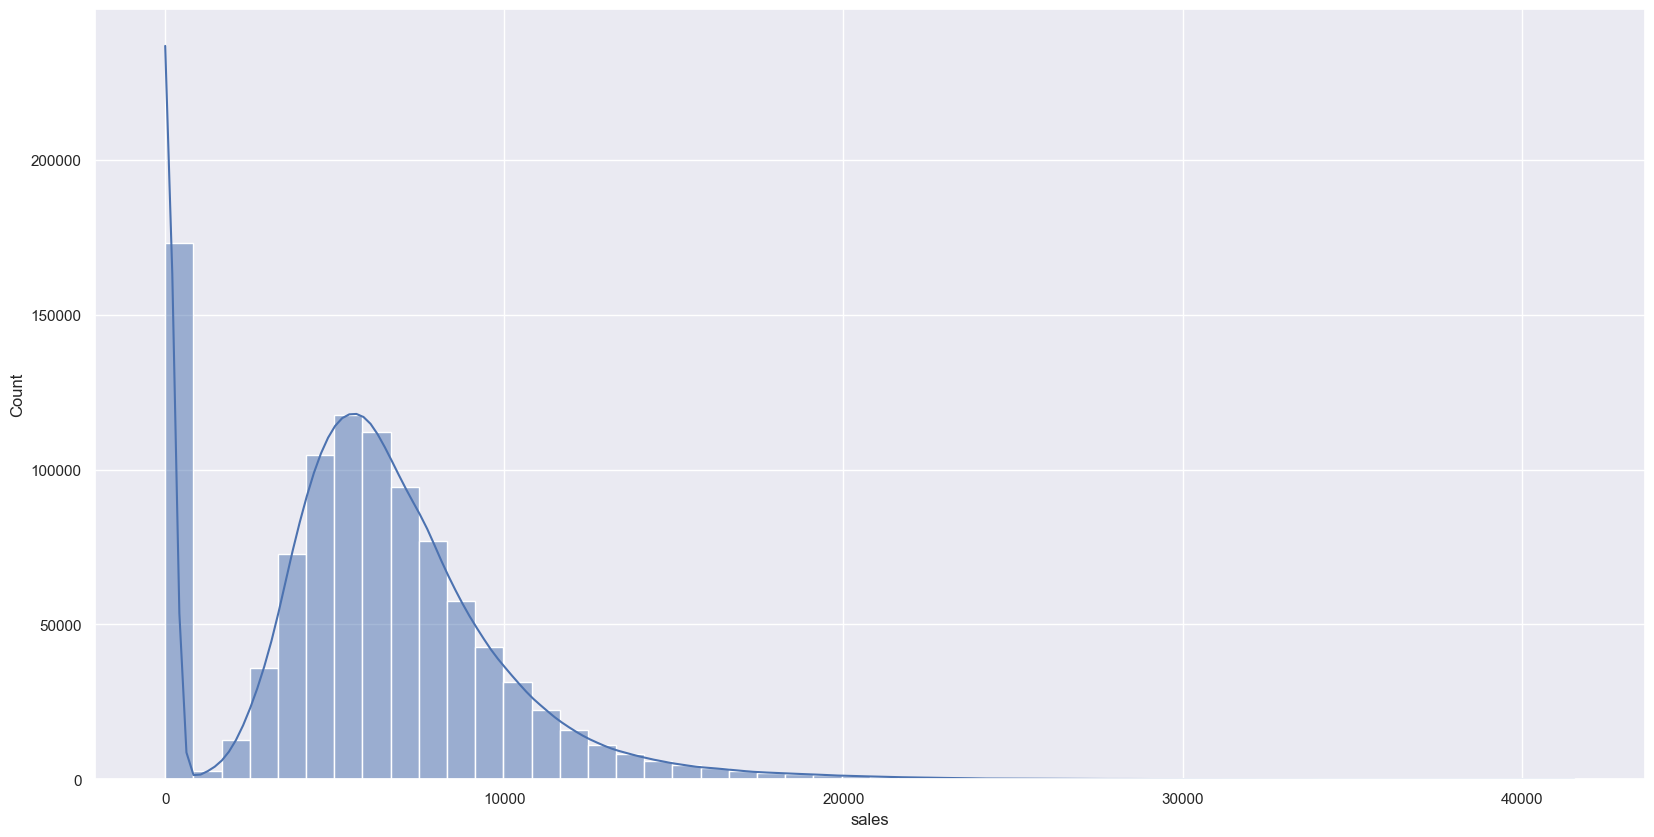

In [20]:
sns.histplot(df1['sales'], kde = True, bins = 50);

A variável resposta (sales) apresenta muitos valores zero (0), que são os dias em que a loja não abriu, trataremos isto no feature engineering.  
As variáveis de ano, mês e semana transformaremos em uma única variável data e da variável date construiremos outras variáveis para extrair informações e testar hipóteses.

### Variáveis Categóricas

In [21]:
cat_attributes = df1.select_dtypes('object')
cat_attributes.describe().T

,count,unique,top,freq
state_holiday,1017209,4,0,986159
store_type,1017209,4,a,551627
assortment,1017209,3,a,537445
promo_interval,1017209,4,0,508031
month_date,1017209,12,May,103695


C:\Users\prpau\AppData\Local\Temp\ipykernel_15744\3345575896.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


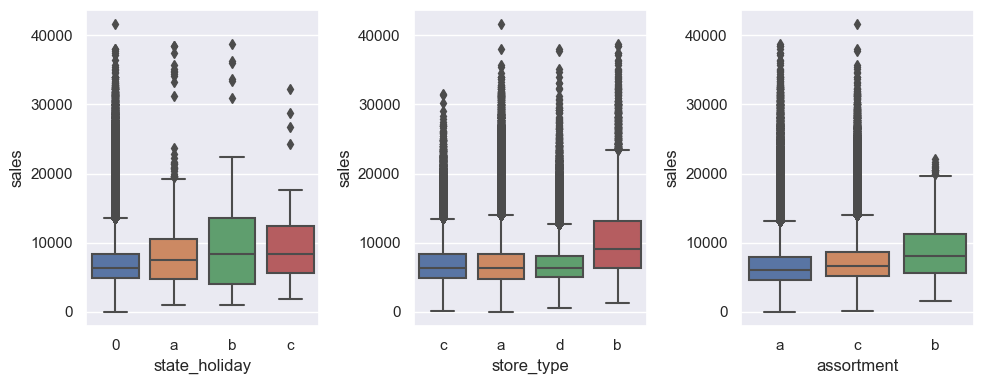

In [22]:
df_aux = df1[(df1['sales'] > 0)]
plt.subplots(figsize = (10,4))

plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y = 'sales', data = df_aux);
plt.tight_layout()

plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y = 'sales', data = df_aux);
plt.tight_layout()


plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y = 'sales', data = df_aux);
plt.tight_layout()


Transformaremos algumas destas variáveis no feature engineering inserindo seus rótulos correspondentes para melhor análise exploratória.

# Feature Engineering

Nesta etapa, são realizadas as transformações e criações de variáveis com base na descrição inicial dos dados e no mapa mental de hipóteses.

### Mapa mental de Hipóteses

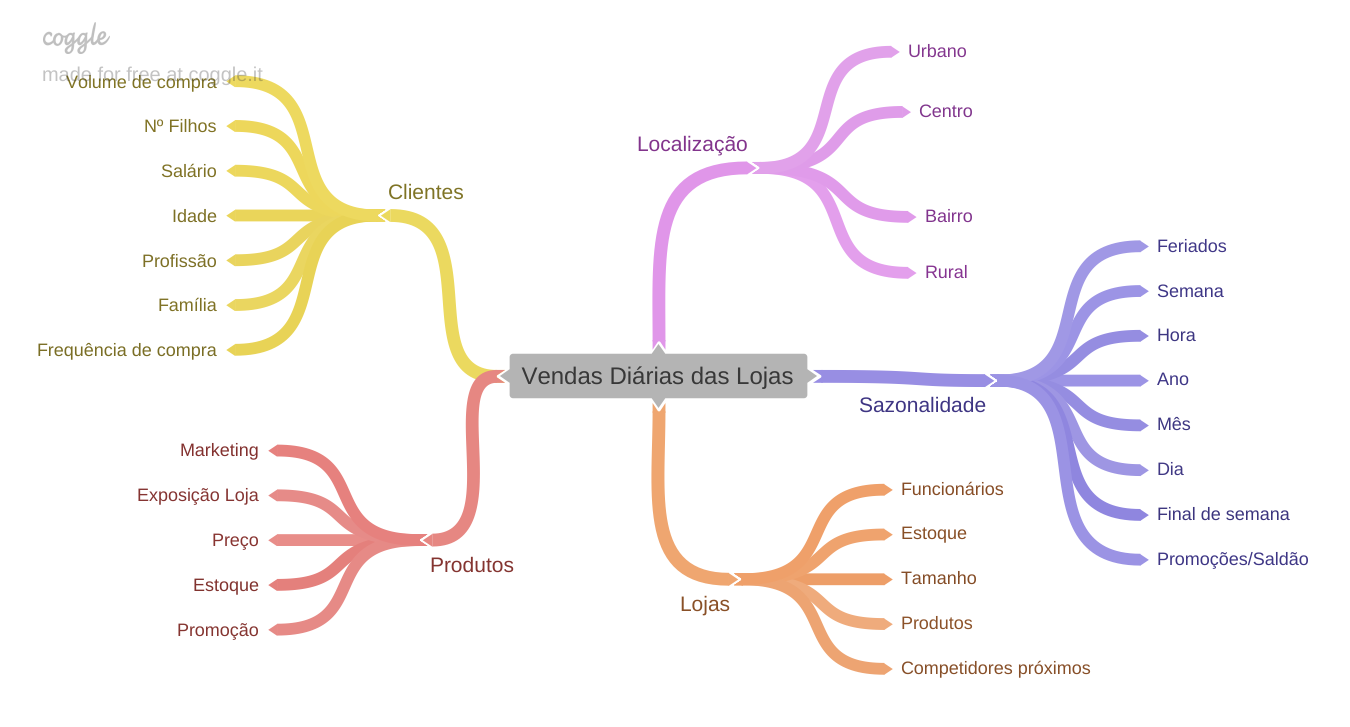

In [23]:
Image('images/mindmap.png')

### Criação das Hipóteses

Hipóteses criadas a partir do mapa mental.

### Loja

***1 -*** Lojas com mais funcionários vendem mais  
***2 -*** Lojas com maior estoque vende mais  
***3 -*** Lojas com maior porte vendem mais  
***4 -*** Lojas com maior variedade de produtos vendem mais  
***5 -*** Lojas com competidores mais próximos vendem menos  
***6 -*** Lojas com competidores há mais tempo vendem mais  

### Produto

***1 -*** Lojas que investem mais em marketing vendem mais  
***2 -*** Lojas que expõe mais os produtos nas vitrines vendem mais  
***3 -*** Lojas com preços menores nos produtos vendem mais  
***4 -*** Lojas com promoções maiores vendem mais  
***5 -*** Lojas com promoções ativas por mais tempo vendem mais  
***6 -*** Lojas com mais promoções consecutivas vendem mais

### Tempo

***1 -*** Lojas com mais feriados vendem menos   
***2 -*** Lojas vende mais no Natal    
***3 -*** Lojas vendem mais ao longo dos anos  
***4 -*** Lojas vendem mais no ssegundo semestre  
***5 -*** Lojas vendem menos nos finais de semana

### Lista Final Hipóteses

Hipóteses filtradas a partir dos dados existentes:

* Lojas com maior variedade de produtos vendem mais    
* Lojas com competidores mais próximos vendem menos  
* Lojas com competidores há mais tempo vendem mais  
* Lojas com promoções ativas por mais tempo vendem mais  
* Lojas com mais promoções consecutivas vendem mais
* Lojas com mais feriados vendem menos   
* Lojas vende mais no Natal
* Lojas vendem mais ao longo dos anos  
* Lojas vendem mais no segundo semestre  
* Lojas vendem menos nos finais de semana

In [24]:
df2 = df1.copy()

Extraindo os tempos necessários da variável date.

In [25]:
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['week_year'] = df2['date'].dt.isocalendar().week
df2['year_and_week'] = df2['date'].dt.strftime('%Y-%W')

Criando variáveis para contagem de tempo de competição

In [26]:
df2['competition_since'] = list(map(lambda x : datetime(year = x[0], 
                        month = x[1], day = 1), 
                        df2[['competition_open_since_year', 'competition_open_since_month']].values))

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days)

Criando variáveis para contagem de tempo de promoção.

In [27]:
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = list(map(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days = 7), 
                df2['promo_since']))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days)

Colocando rótulos para variáveis categóricas.

In [28]:
#assortiment
df2['assortment_label'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extend')

#state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                        else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# Filtragem Variáveis

Com base em regras de negócio e restrições específicas, algumas linhas e variáveis serão removidas.  
A variável 'customers' não estará disponível para previsões com novos dados e, portanto, será excluída.   
Além disso, lojas fechadas não realizam vendas, então essas linhas serão removidas, assim como as vendas com valor zero.  
Também serão excluídas algumas colunas que foram transformadas no Feature Engineering.

In [30]:
df3 = df2.copy()

## Filtragem de linhas

In [31]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Seleção de colunas

In [32]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_date']
df3 = df3.drop(cols_drop, axis = 1)

# Análise Exploratória de Dados

In [33]:
df4 = df3.copy()

## Análise Univariada

### Variável resposta

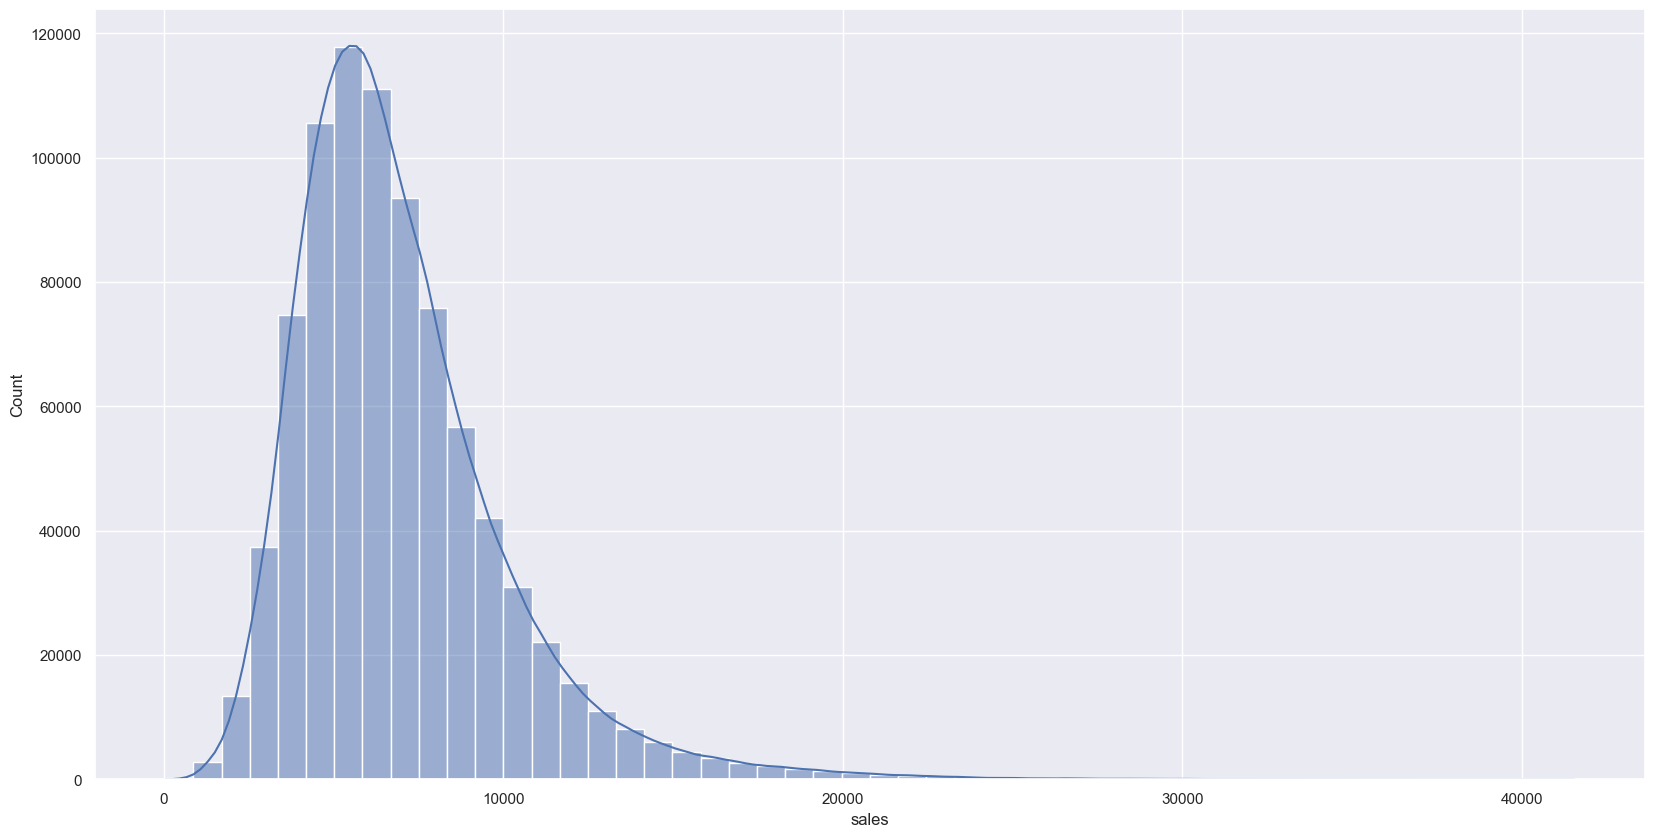

In [34]:
sns.histplot(df4['sales'], kde = True, bins = 50);

A variável sale apresenta uma distribuição com assimetria a esquerda, os valores se acumulam nos valores menores.

### Variáveis Numéricas

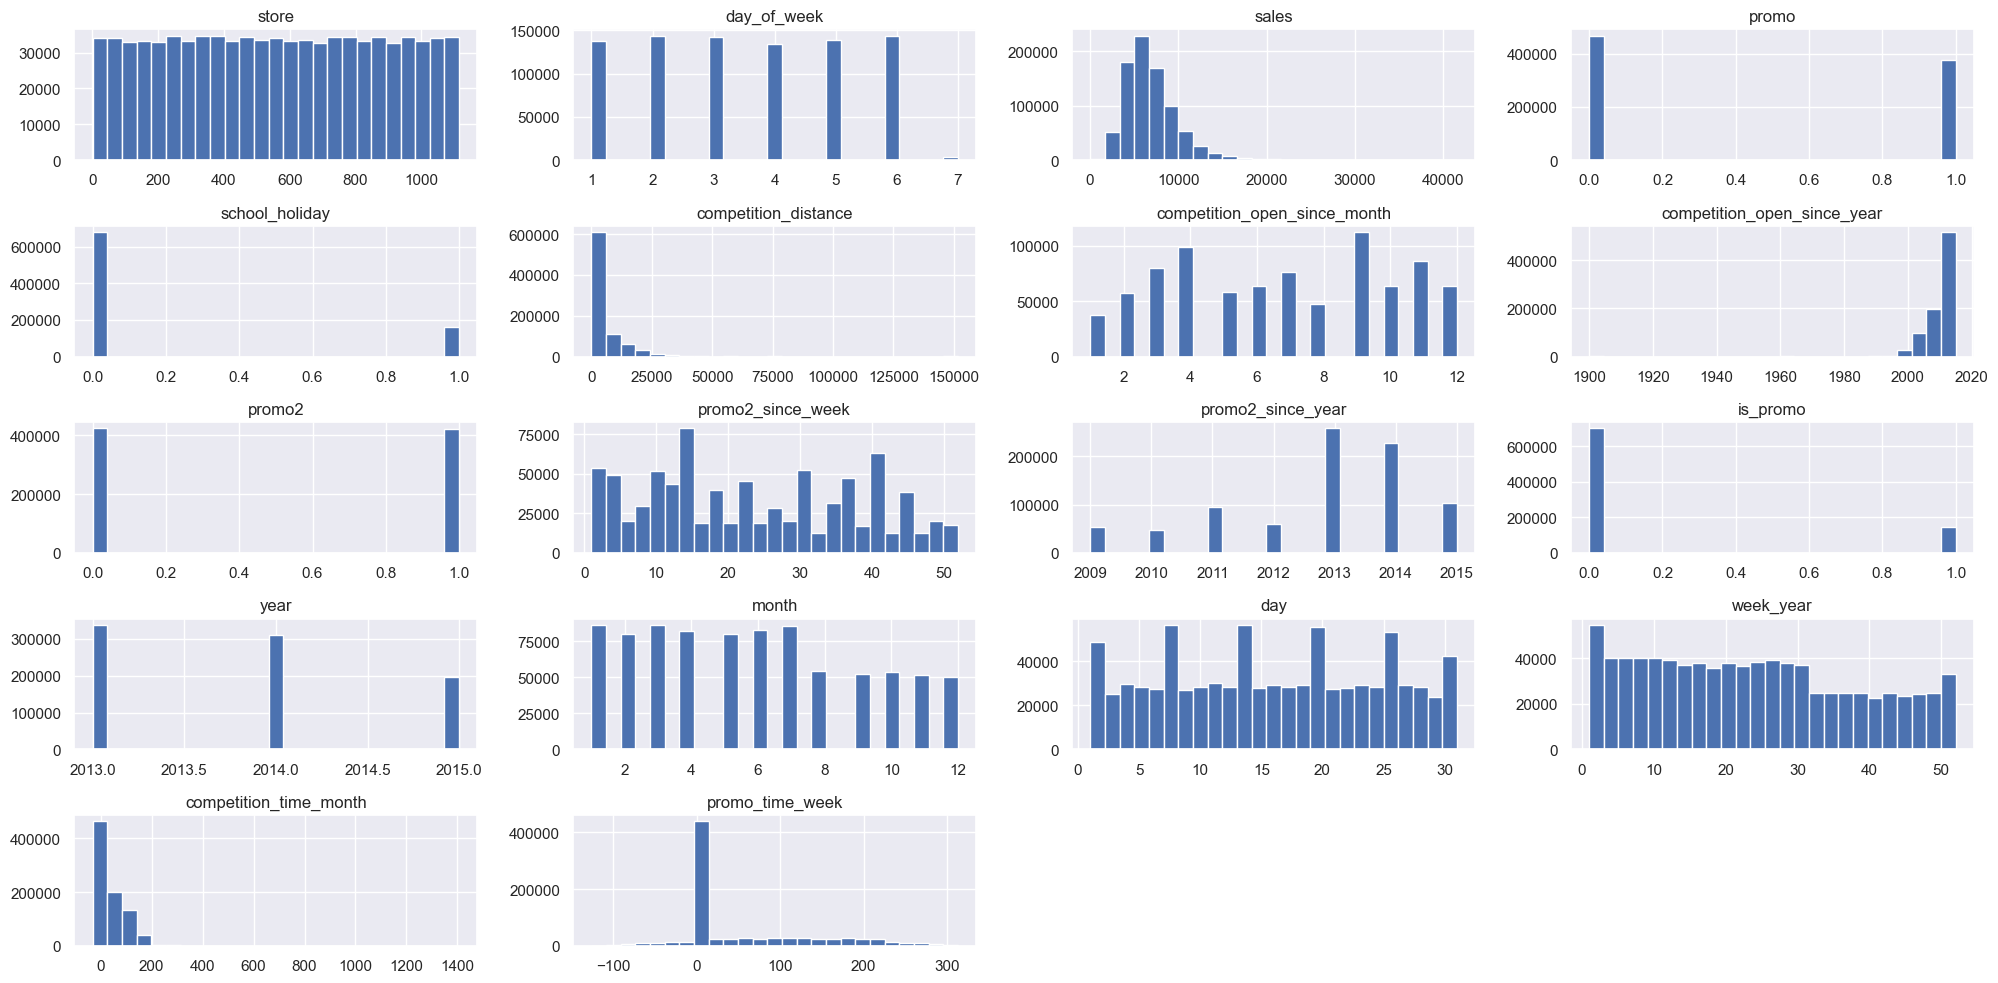

In [35]:
num_attributes = df4.select_dtypes('number')
num_attributes.hist(bins = 25);
plt.tight_layout()

As vendas durante a semana são constantes, apenas domingo (dia 7 da semana) é bem pouco devido a ser raro as lojas abrirem.  
A maioria das lojas possuem competidores próximos.  
Os competidores abrem mais lojas nos meses 9 e 4.  
As lojas tiveram mais competidores no último ano.  
Há maior quantidade de vendas quando não tem promoção.  
Há maior quantidade de vendas nos primeiros 7 meses, nos últimos meses tem constancia menor de vendas.  
Houve um pico de vendas nas promoçoes de 2013 e após constante queda até 2015.

### Variáveis categóricas

In [36]:
df4.select_dtypes('object').columns

Index(['state_holiday', 'store_type', 'assortment', 'year_and_week',
       'assortment_label'],
      dtype='object')

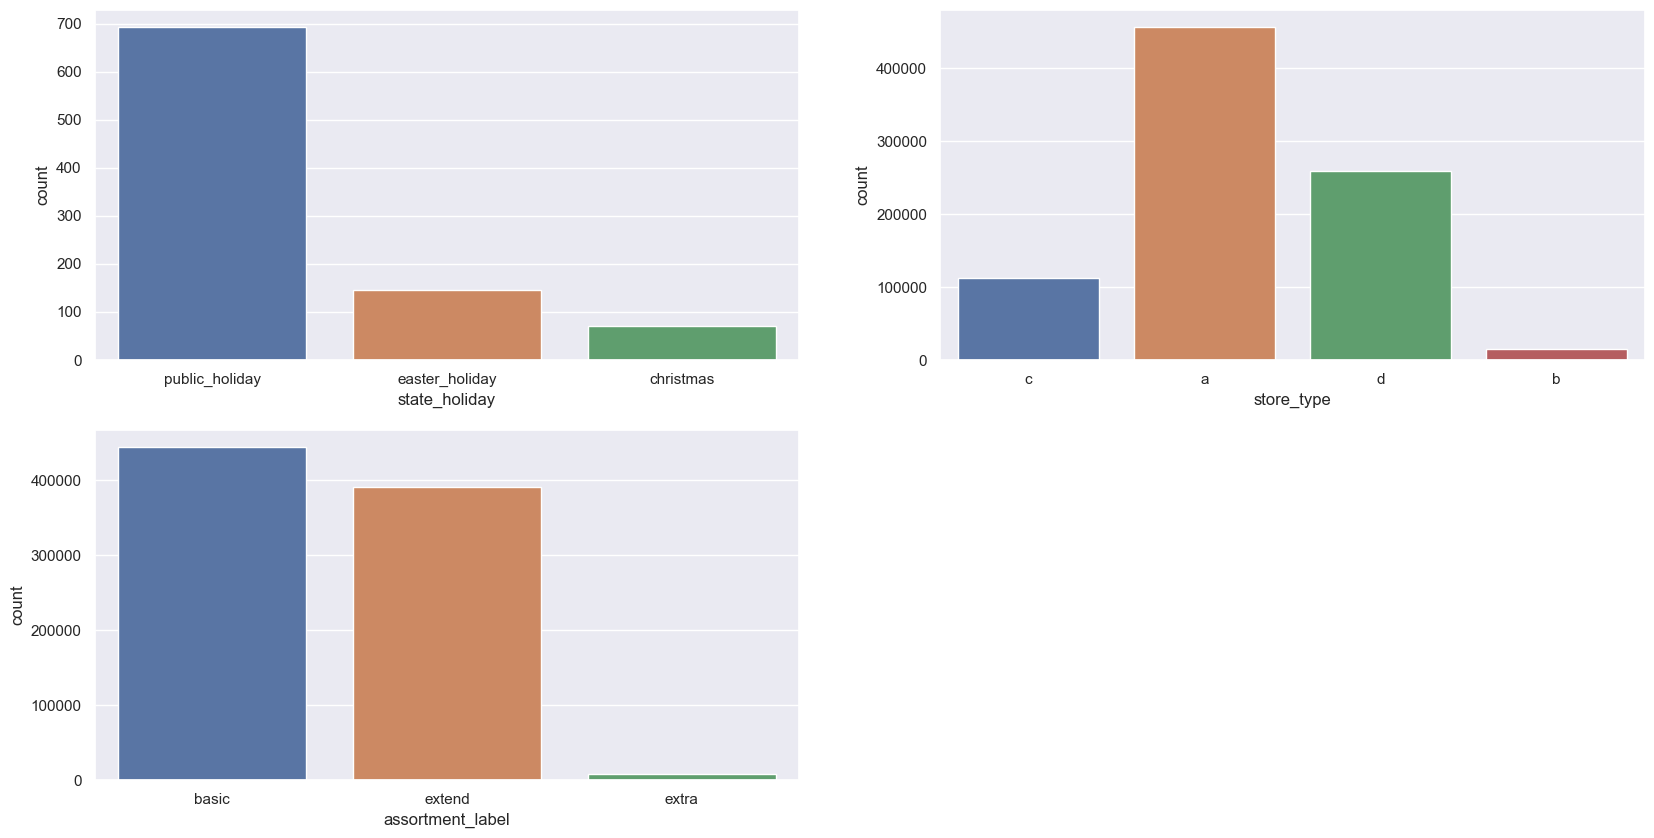

In [37]:
holiday = df4[(df4['state_holiday'] != 'regular_day')]

plt.subplot(221)
sns.countplot(x = holiday['state_holiday']);

# plt.subplot(322)
# sns.kdeplot(data = holiday, x = 'sales', hue = 'state_holiday', fill = True)
# plt.title('Sales holiday');

plt.subplot(222)
sns.countplot(x = df4['store_type']);

# plt.subplot(324)
# sns.kdeplot(data = df4, x = 'sales', hue = 'store_type', fill = True)
# plt.title('Sales store type')

plt.subplot(223)
sns.countplot(x = df4['assortment_label']);

# plt.subplot(326)
# sns.kdeplot(data = df4, x = 'sales', hue = 'assortment_label', fill = True);
# plt.title('Sales assortment');
# plt.tight_layout();

## Análise Bivariada

Análise das variáveis buscando validar as hipóteses anteriormente criadas

#### H1. Lojas com maior variedade de produtos vendem mais.
_**Não validada, lojas com maior variedade(assortment) vendem menos.**_

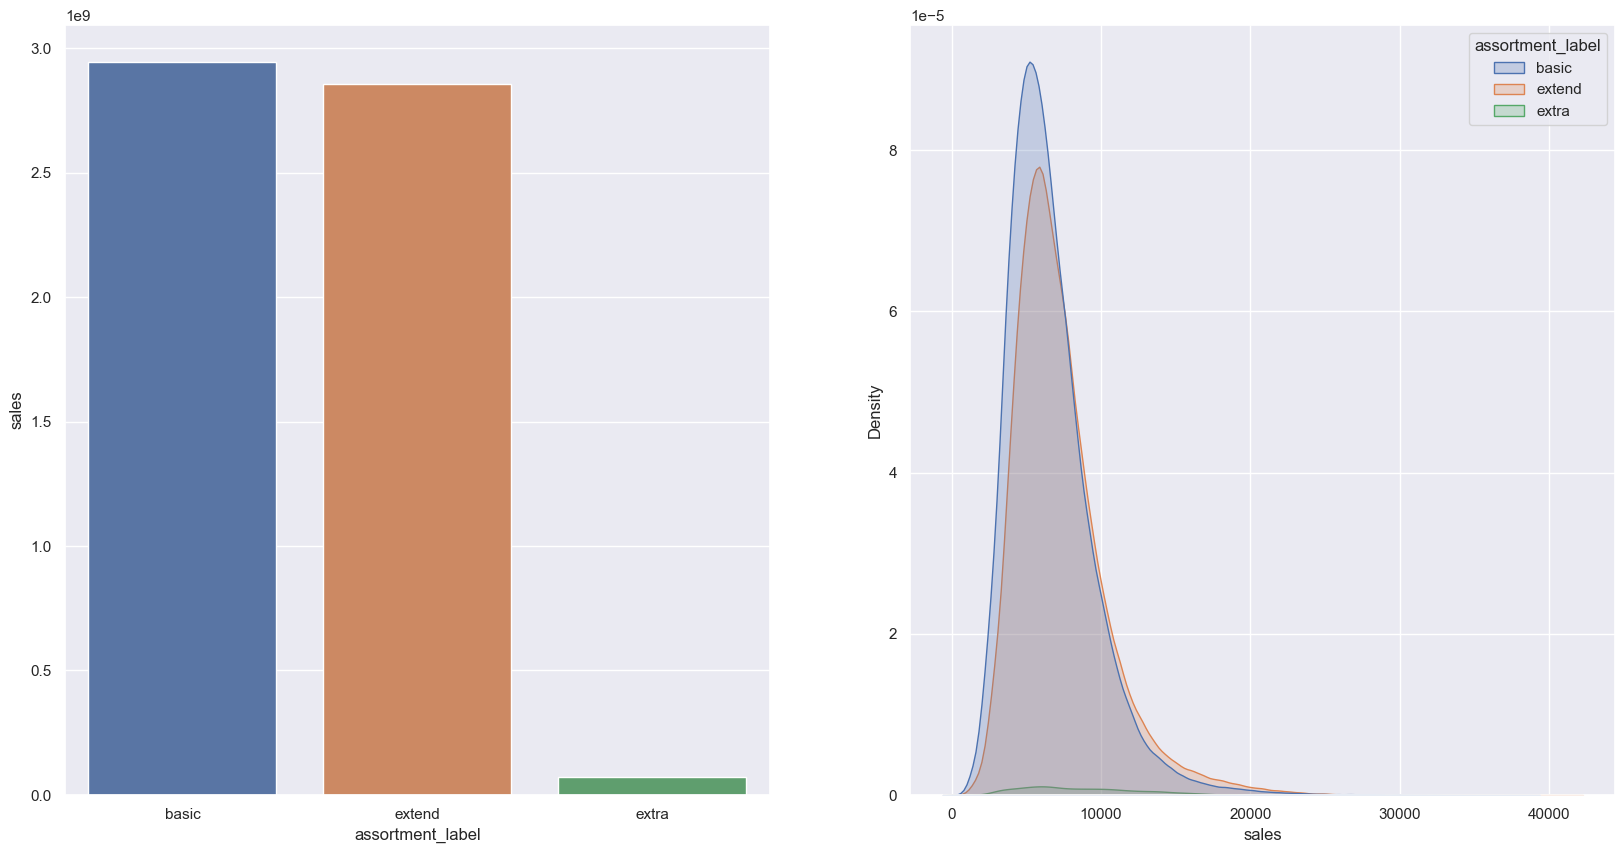

In [38]:
aux1 = df4[['sales', 'assortment_label']].groupby('assortment_label').sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'assortment_label', y = 'sales', data = aux1);

plt.subplot(122)
sns.kdeplot(data = df4, x = 'sales', hue = 'assortment_label', fill = True);


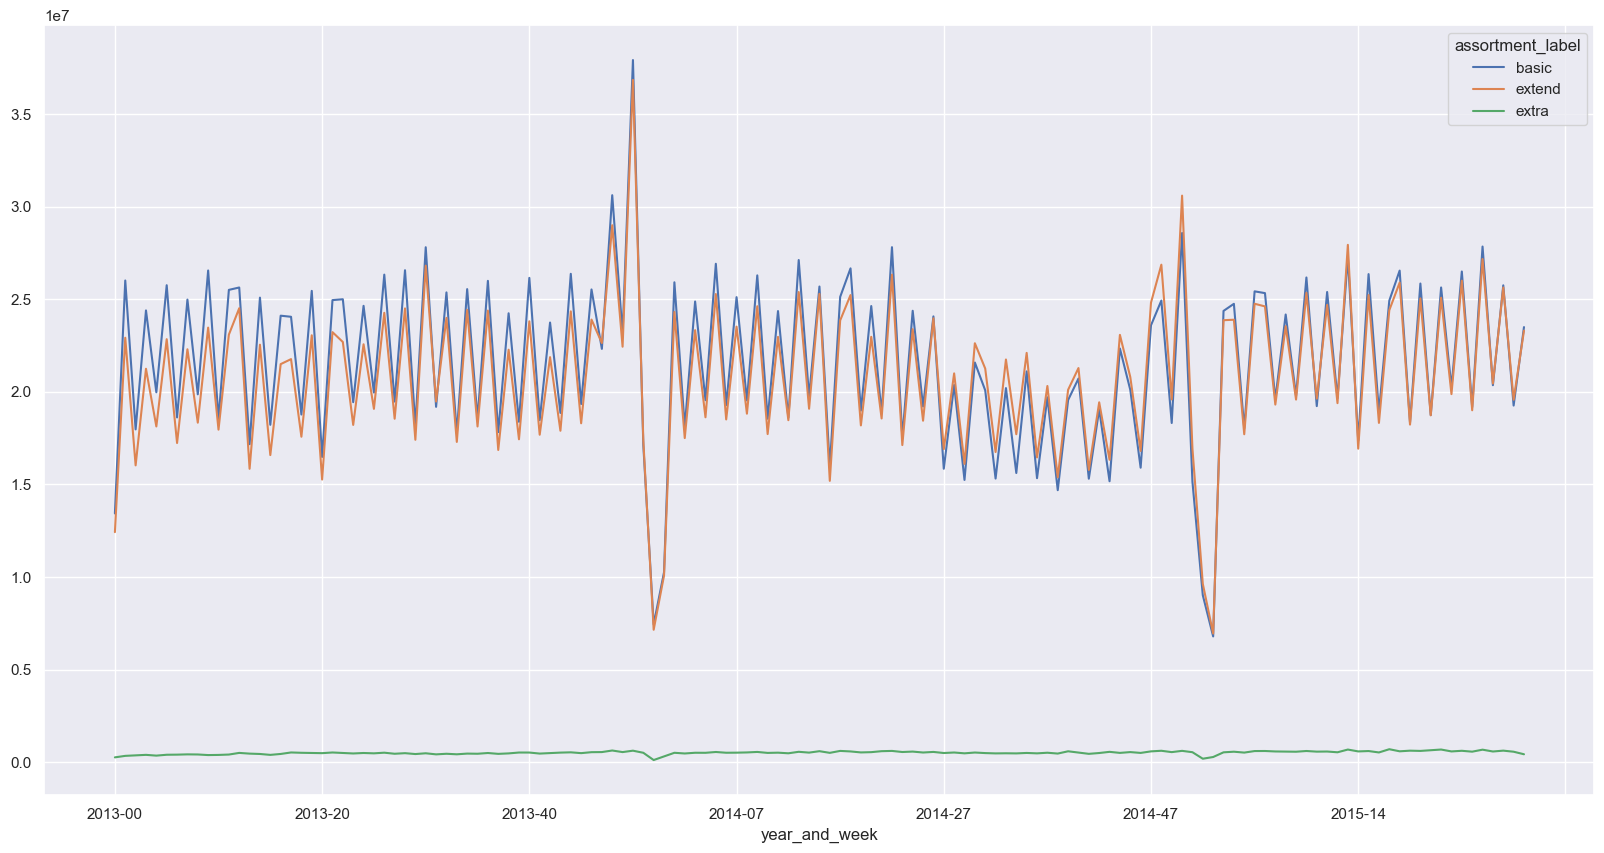

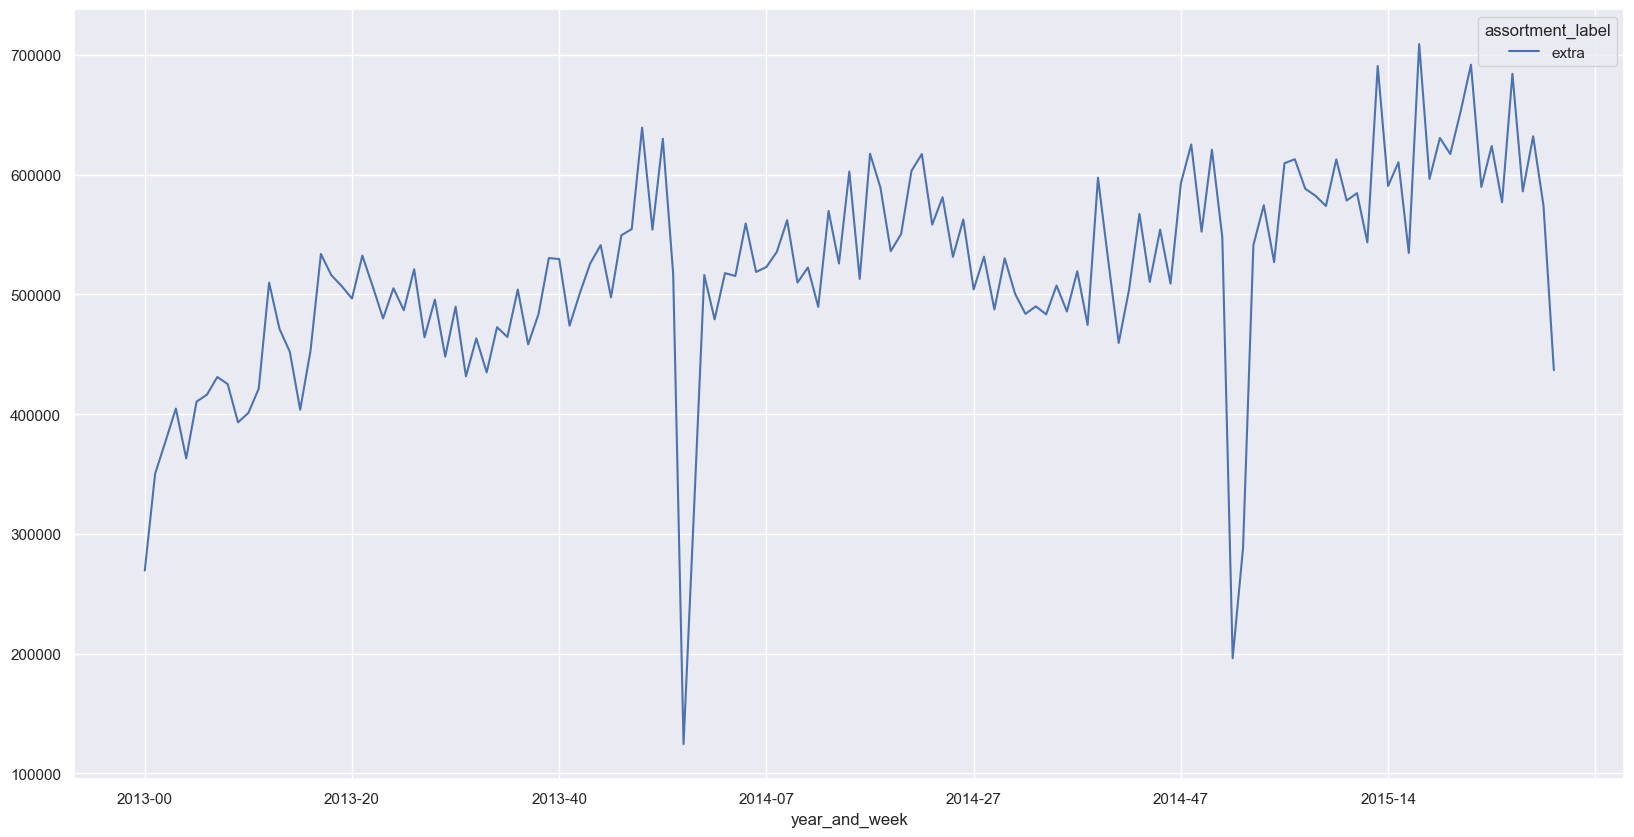

In [39]:
aux2 = df4[['year_and_week','sales', 'assortment_label']].groupby(['year_and_week','assortment_label']).sum().reset_index()
aux2.pivot(index = 'year_and_week', columns = 'assortment_label', values = 'sales').plot();

aux3 = aux2[aux2['assortment_label'] == 'extra']
aux3.pivot(index = 'year_and_week', columns = 'assortment_label', values = 'sales').plot();

Considerando 'extra' como lojas de maior variedade/sortimento a hipótese nao é validada, este tipo de loja vende menos.  
Basic e extends são semelhantes em vendas e se comportam igualmente ao longo do tempo. O grupo mais distinto e com poucas vendas é o 'extra', observando-o ao longo do tempo, a tendência não é linear como parece mostrar no primeiro gráfico. Parece haver uma sazonalidade onde se vende menos neste tipo de loja. 

#### H2. Lojas com competidores mais próximos vendem menos.
_**Não validada, lojas com competidores mais próximos vendem mais.**_

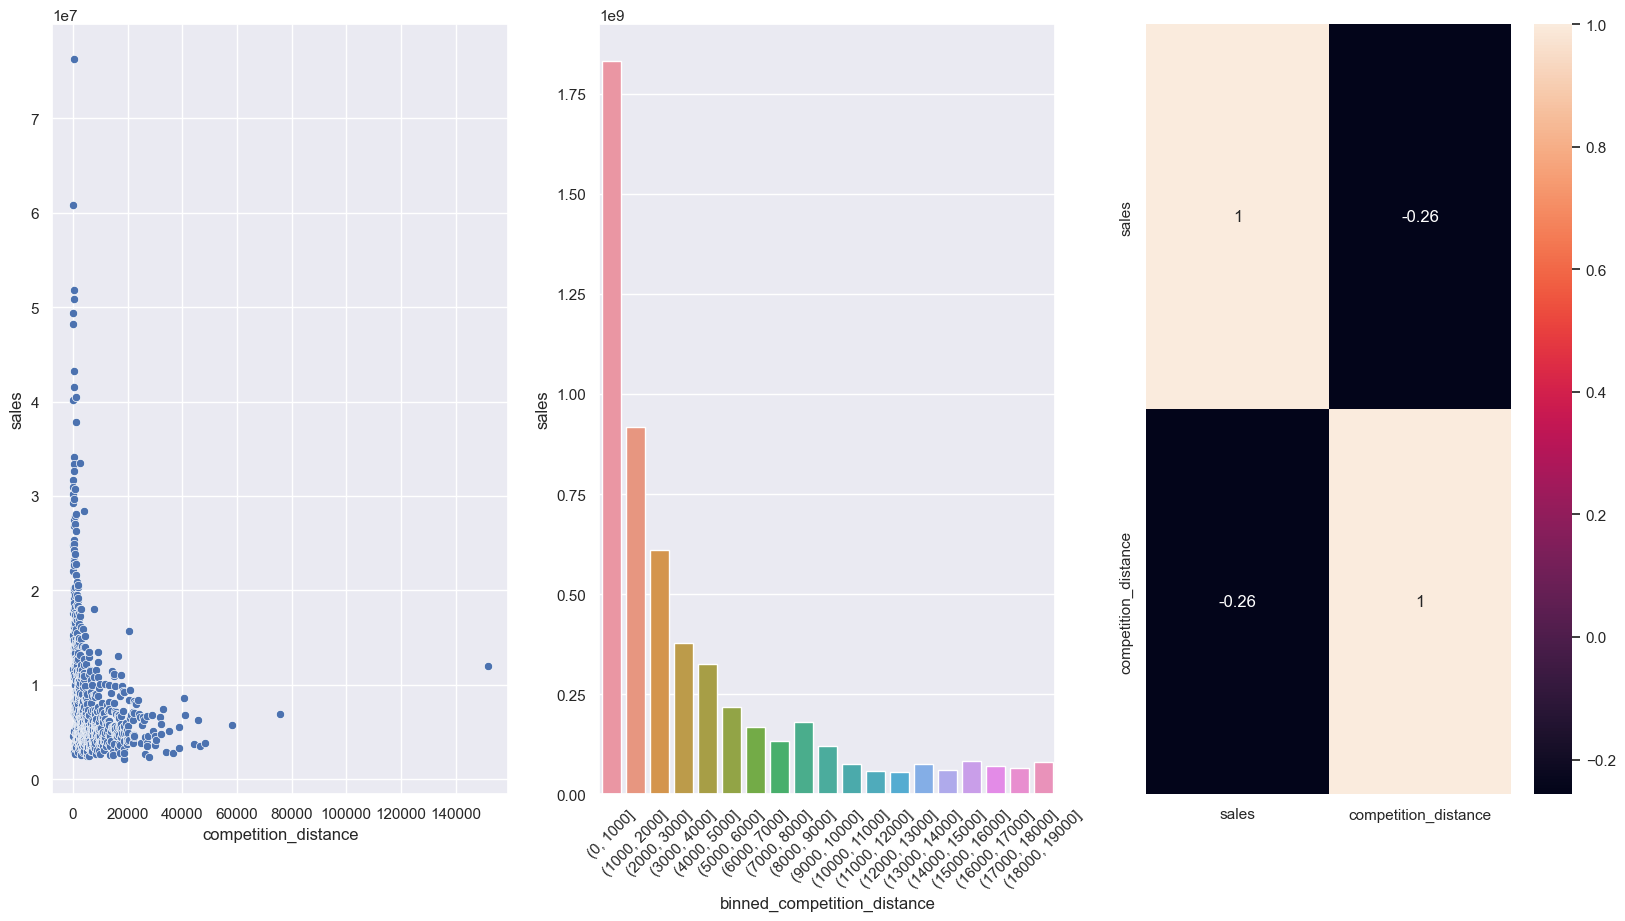

In [40]:
aux1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

plt.subplot(131)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(132)

bins = list(np.arange(0,20000,1000))
aux1['binned_competition_distance'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['sales', 'binned_competition_distance']].groupby('binned_competition_distance').sum().reset_index()

sns.barplot(x = 'binned_competition_distance', y = 'sales', data = aux2);
plt.xticks(rotation = 45);

plt.subplot(133)
sns.heatmap(aux1[['sales', 'competition_distance']].corr(method = 'pearson'), annot = True);

Os gráficos mostram o contrário da hipótese, lojas com competidores mais próximos tendem a vender mais, e a correlação mostra esta tendência decrescente. 

#### Lojas com competidores há mais tempo vendem mais.
_**Não validada, lojas com competidores há mais tempo vendem menos.**_

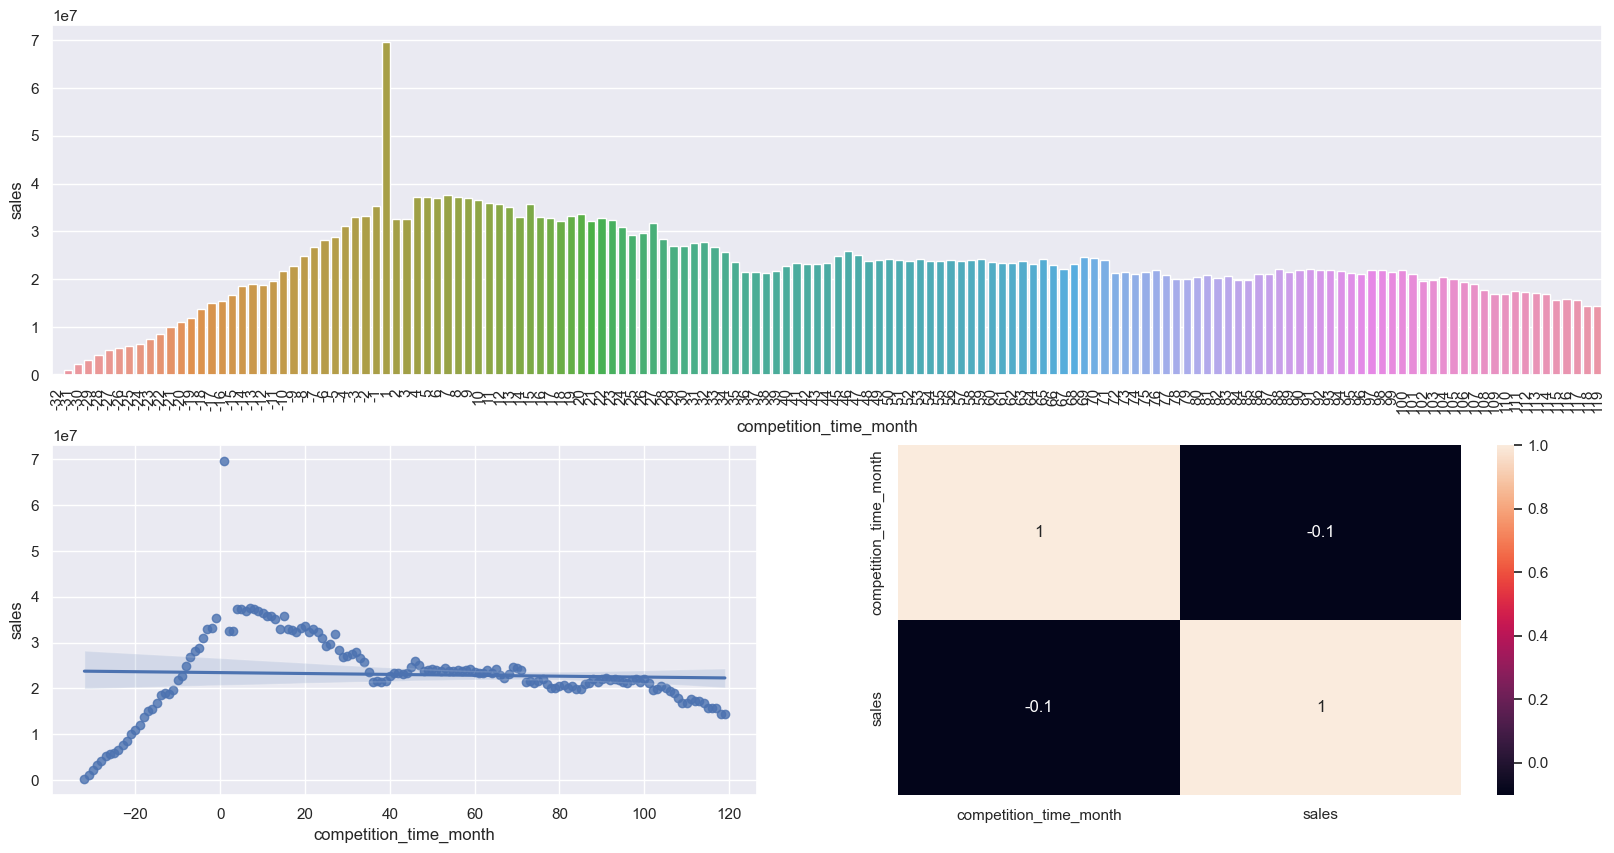

In [41]:
aux1 = df4[['sales', 'competition_time_month']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(211)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(223)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(224)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

Como comparamos a data da venda com a data de abertura do concorrente há valores negativos pois alguns competidores abriram loja depois da data de venda. Podemos observar que quanto mais próximo de 0, ou seja, mais recente a competição, maior são as vendas. A competição tem bastante impacto nas vendas, podemos notar uma tendência decrescente mas não é uma correlação linear.

#### Lojas com promoções ativas por mais tempo vendem mais .
_**Não validada, lojas com promoções ativas tem uma regularidade de vendas durante um tempo, após, começa a declinar.**_

C:\Users\prpau\AppData\Local\Temp\ipykernel_15744\409018462.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2['binned_promo_time'] = pd.cut(aux1['promo_time_week'], bins = bins)


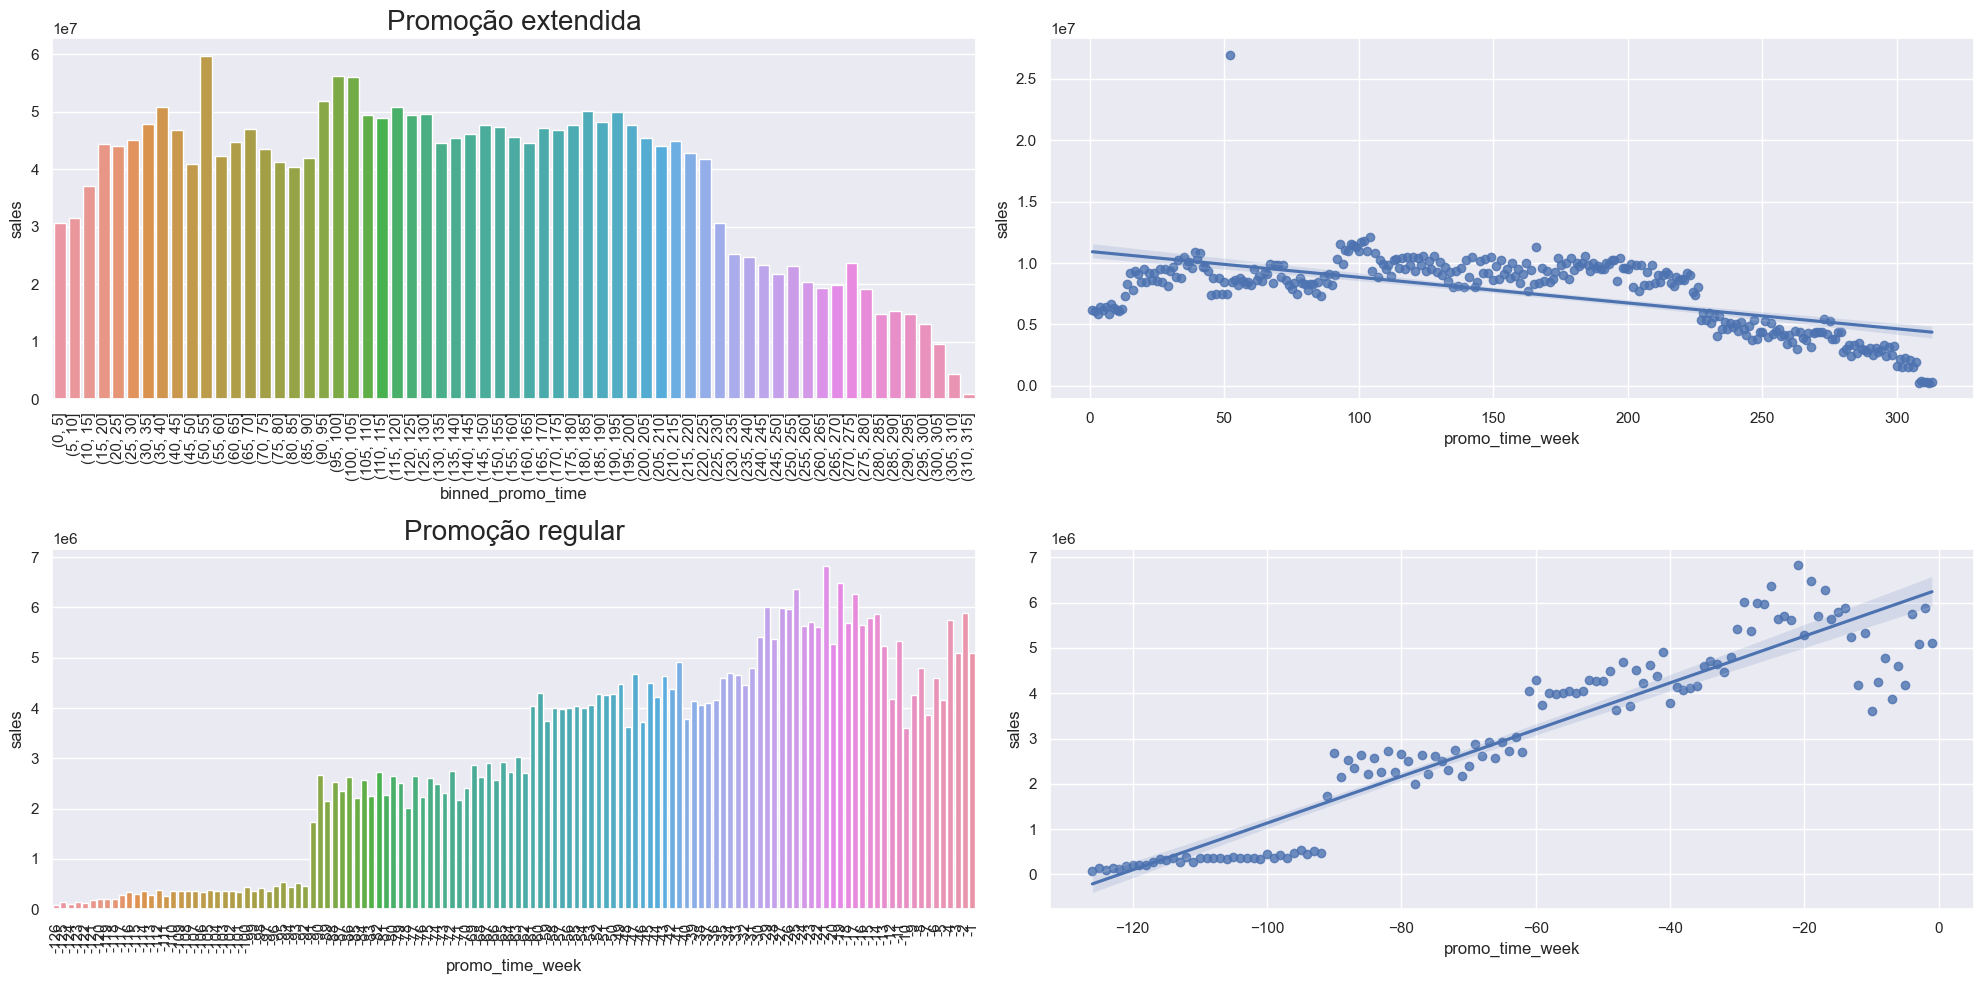

In [42]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
aux2 = aux1[aux1['promo_time_week'] > 0] # tempo promoção extendida
 

bins = list(np.arange(0,320,5))
aux2['binned_promo_time'] = pd.cut(aux1['promo_time_week'], bins = bins)
aux3 = aux2[['sales', 'binned_promo_time']].groupby('binned_promo_time').sum().reset_index()

aux4 = aux1[aux1['promo_time_week'] < 0] # tempo promoção regular


plt.subplot(221)
sns.barplot(x = 'binned_promo_time', y = 'sales', data = aux3);
plt.title('Promoção extendida', fontsize = 20)
plt.xticks(rotation = 90);

plt.subplot(222)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(223)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux4);
plt.title('Promoção regular', fontsize = 20)
plt.xticks(rotation = 90);

plt.subplot(224)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux4);
plt.tight_layout();

Na promoção estendida, percebe-se que há um período de efeito em que as vendas atingem um patamar e mantêm-se regulares, mas começa a declinar após a semana 225, o que gera uma reta com tendência negativa. Já na promoção regular, ocorrem saltos de vendas à medida que a promoção estendida se aproxima mostrando um tendência crescente. Portanto, a hipótese de que as vendas aumentam à medida que a promoção se estende não é validada, já que as vendas caem após um período de regularidade.

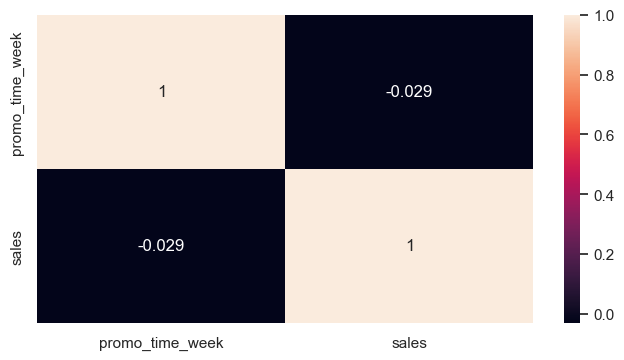

In [43]:
plt.figure(figsize = (8,4))
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

Esta variável apresenta correlação negativa muito baixa, possivelmente afetada pelo período longo de constância na promoção, talvez não seja relevante para o modelo se não for combinada com outra(s) variável(is).

#### Lojas com promoções consecutivas vendem mais.
_**Não validada, lojas com promoção estendida venderam menos.**_

In [44]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by = 'sales', ascending = False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


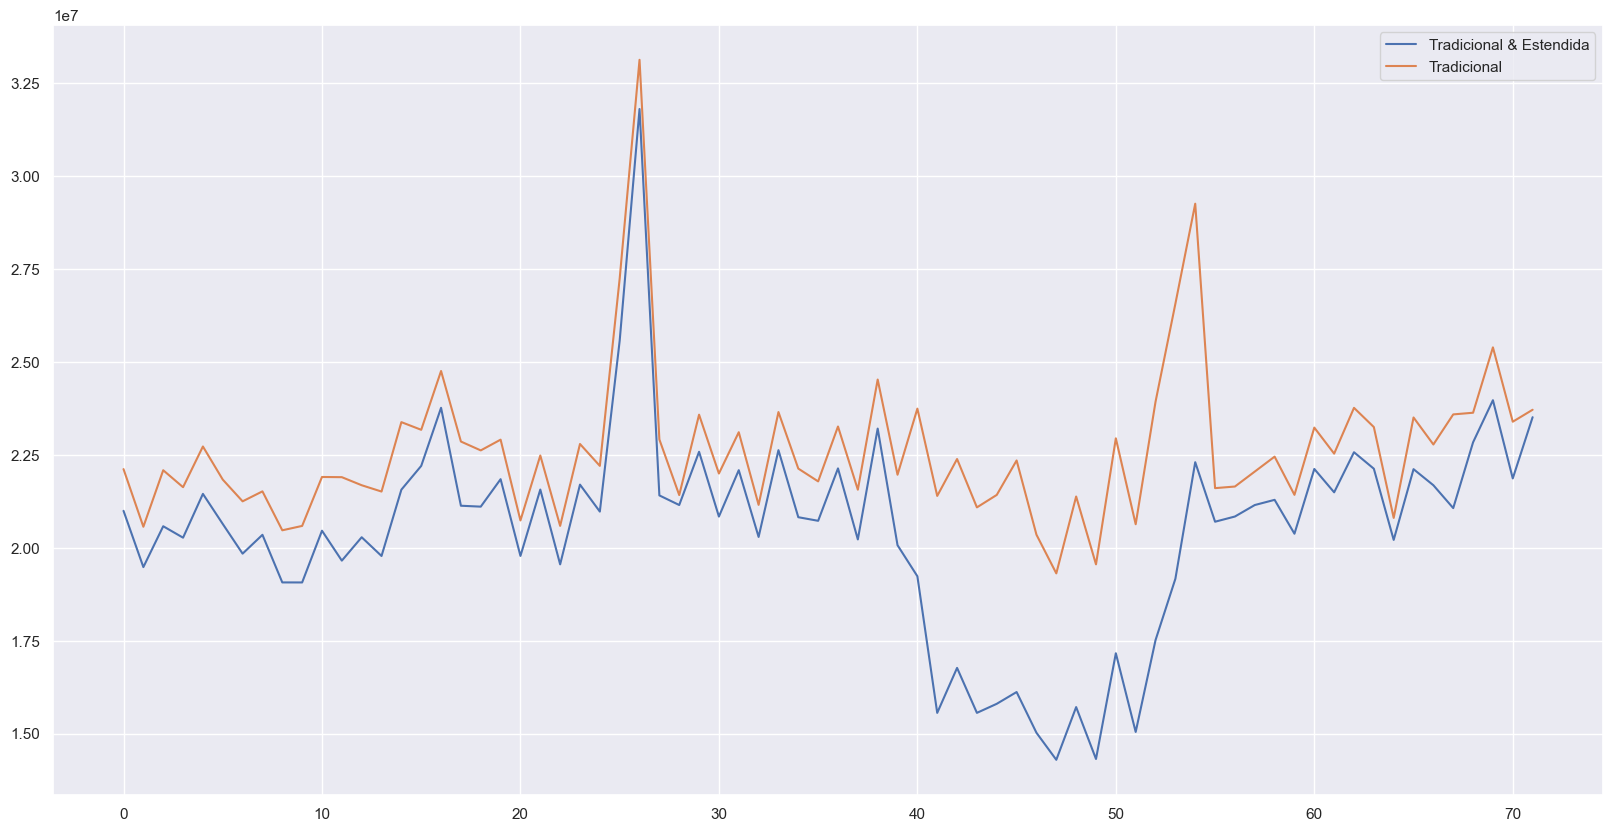

In [45]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_and_week', 'sales']].groupby('year_and_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_and_week', 'sales']].groupby('year_and_week').sum().reset_index()
aux2.plot(ax =ax);

ax.legend(labels = ['Tradicional & Estendida', 'Tradicional']);

Como se observa no gráfico a prorrogação da promoção não aumentam as vendas, contrariando a hipótese. E se percebe nas linhas do gráfico, que na maior parte o comportamento é o mesmo, possivelmente não será uma variável tão relevante para o modelo.

#### Lojas vende mais no Natal
_**Não validada, as lojas vendem menos no feriado de Natal.**_

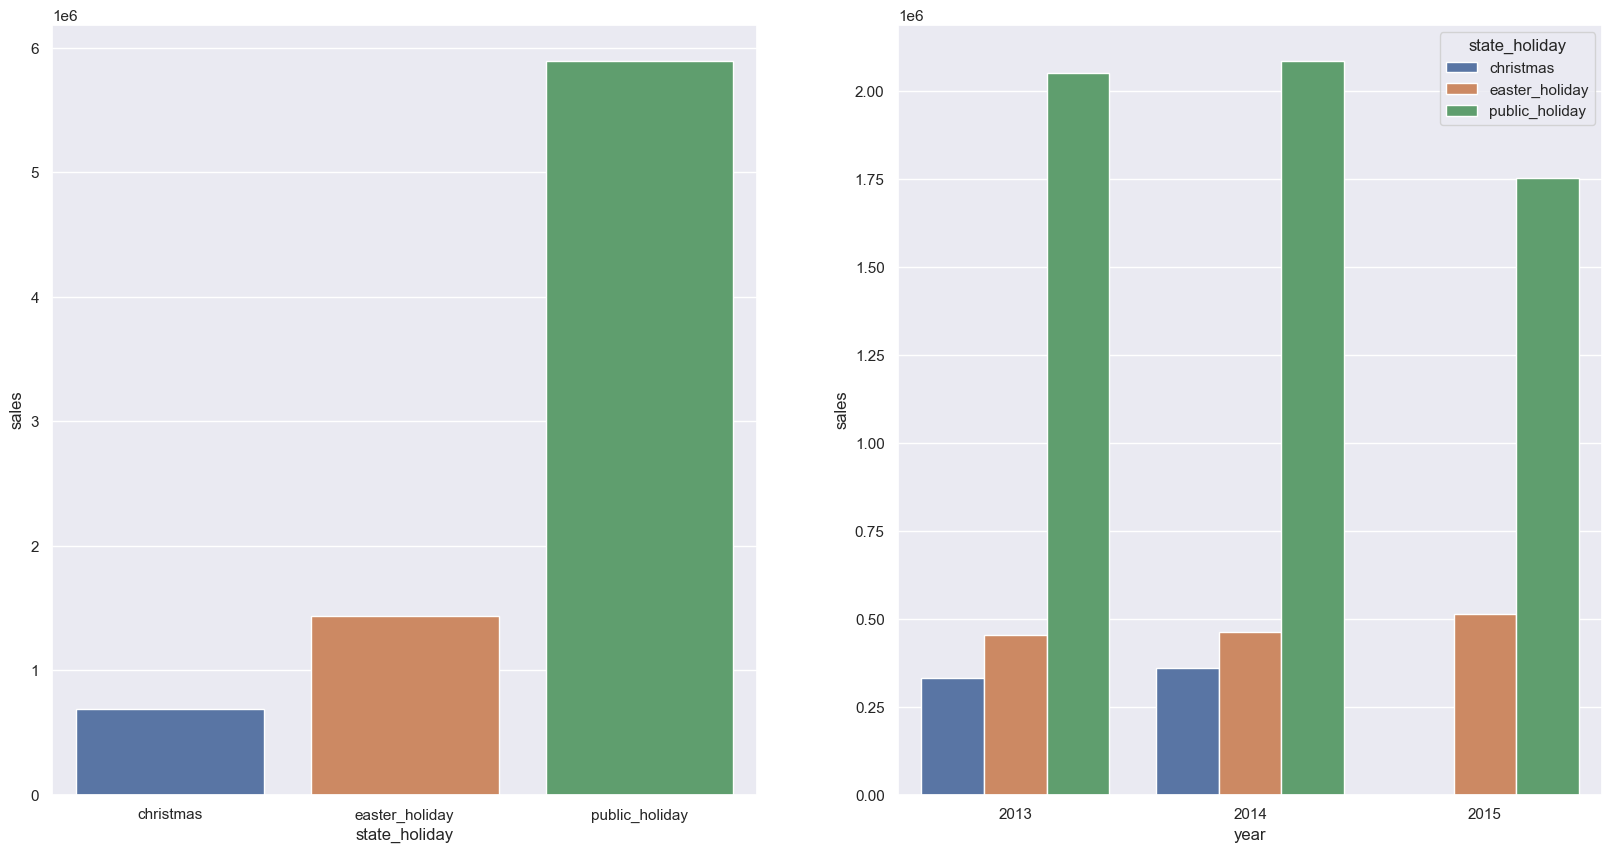

In [46]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'state_holiday', y = 'sales', data = aux2);

plt.subplot(122)
aux3 = aux1[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux3);


#### Lojas vendem mais ao longo dos anos  
_**Não validada, as vendas estão com tendência de queda.**_

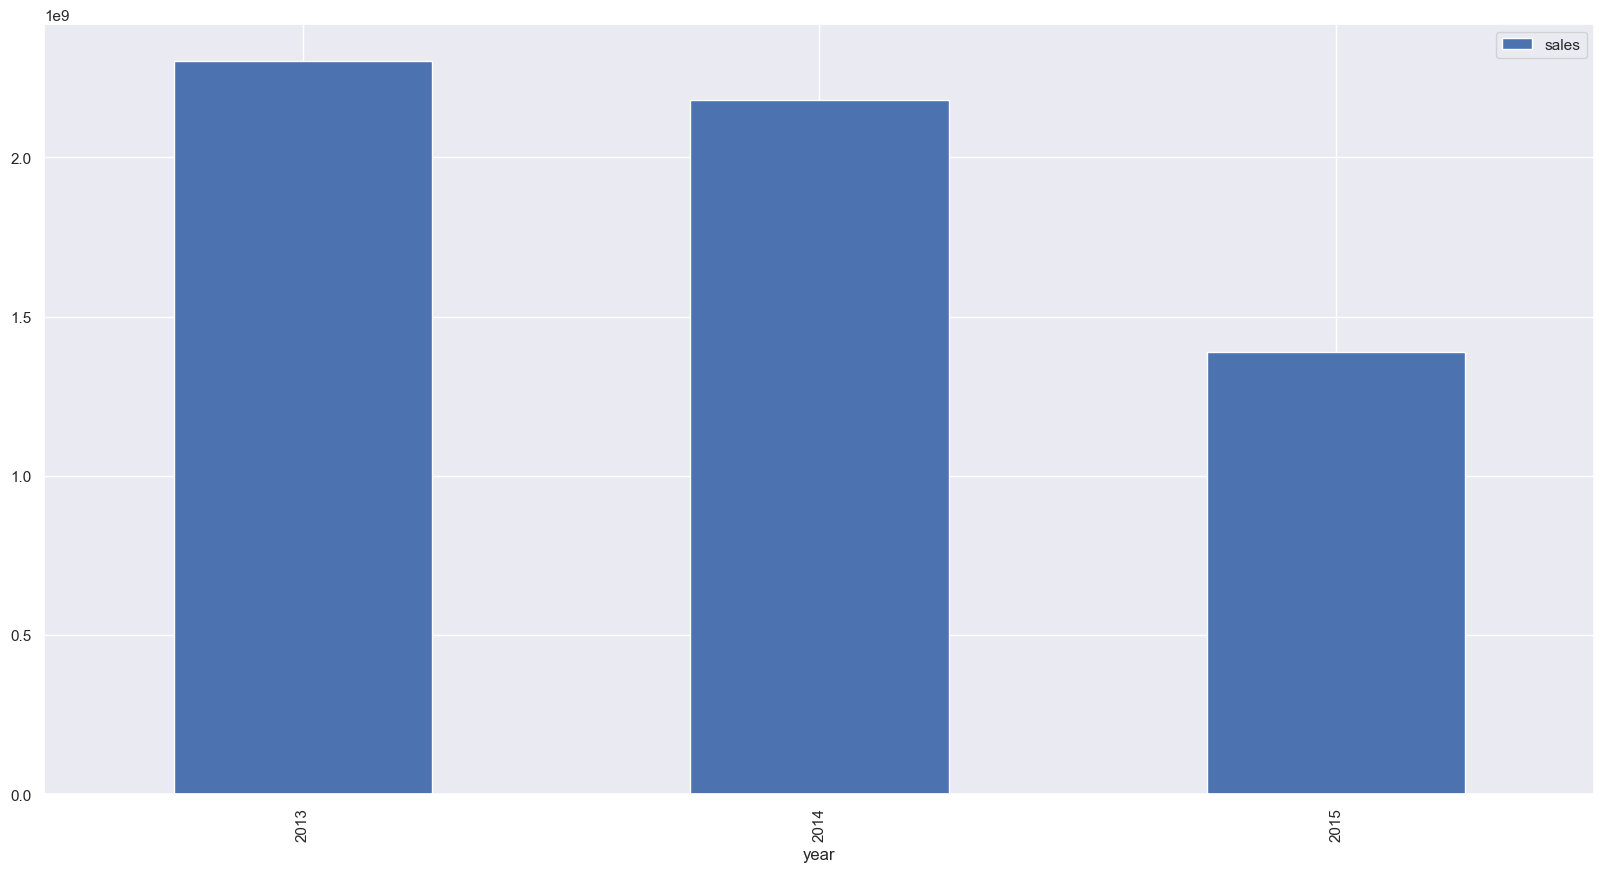

In [47]:
df4[['year', 'sales']].groupby('year').sum().plot(kind = 'bar');

Apesar dos dados do último ano (2015) não estar completo, podemos verificar uma tendência de queda nas vendas.

#### Lojas vendem mais no segundo semestre  
_**Não validada, as lojas vendem menos no segundo semestre.**_

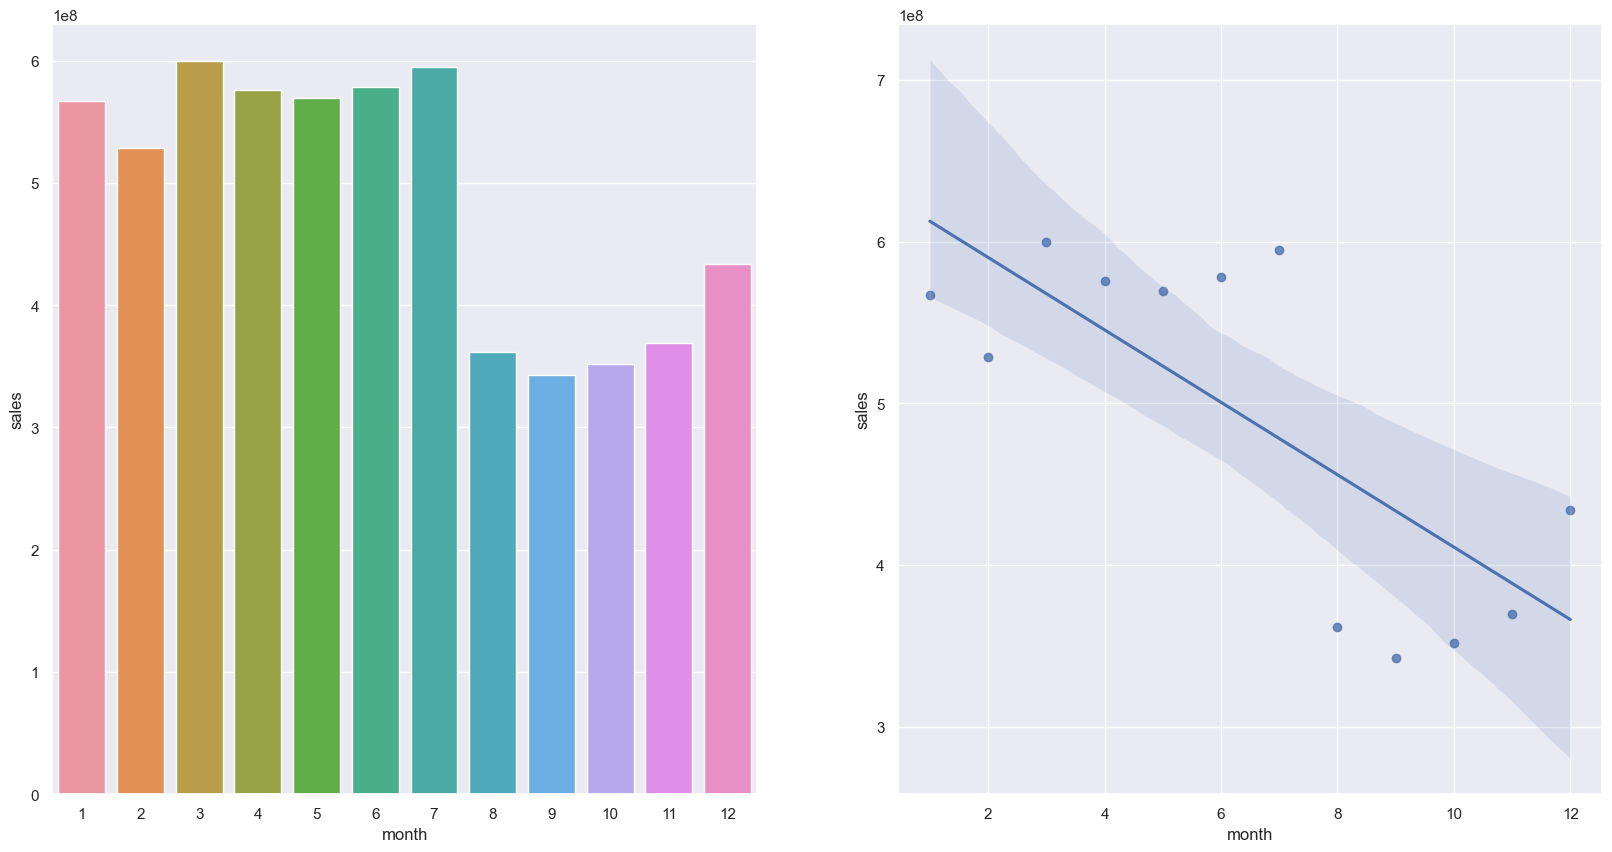

In [48]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(122)
sns.regplot(x = 'month', y = 'sales', data = aux1);

Nos gráficos, notamos o contrário da hipótese, nos primeiros 6 meses há mais vendas, e uma queda notável a partir do 7º mês.

#### Lojas vendem menos nos finais de semana
_**Validada, as vendas caem nos finais de semana.**_

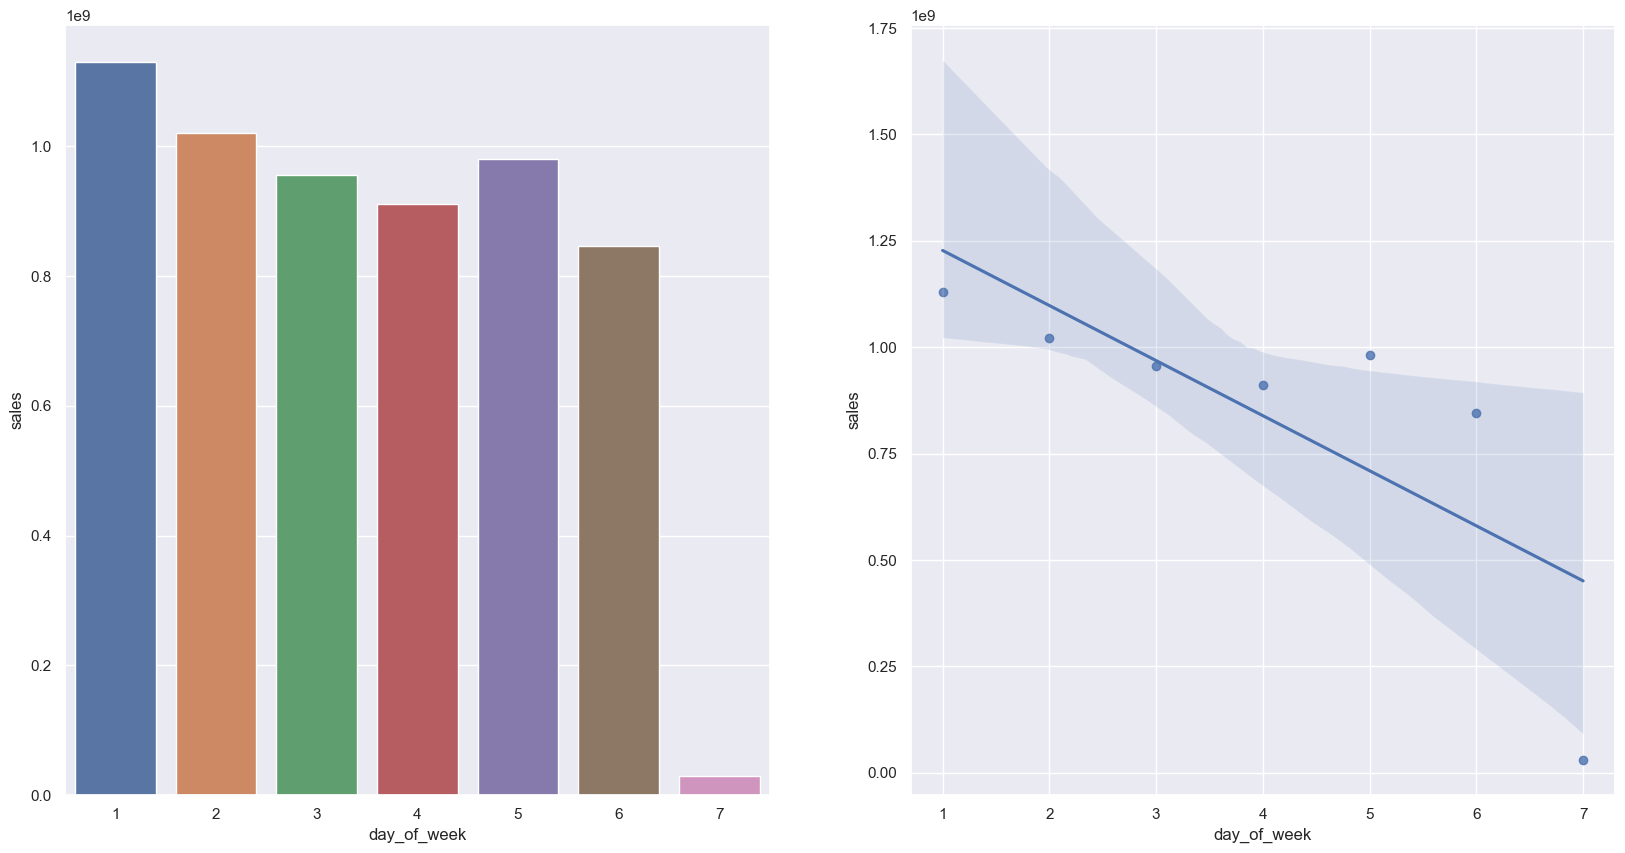

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(122)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

Os gráficos mostram queda nas vendas ao se aproximar dos fins de semana, assim, as vendas tendem a ser maiores em dias de semana.

## Análise Multivariada

### Variáveis númericas

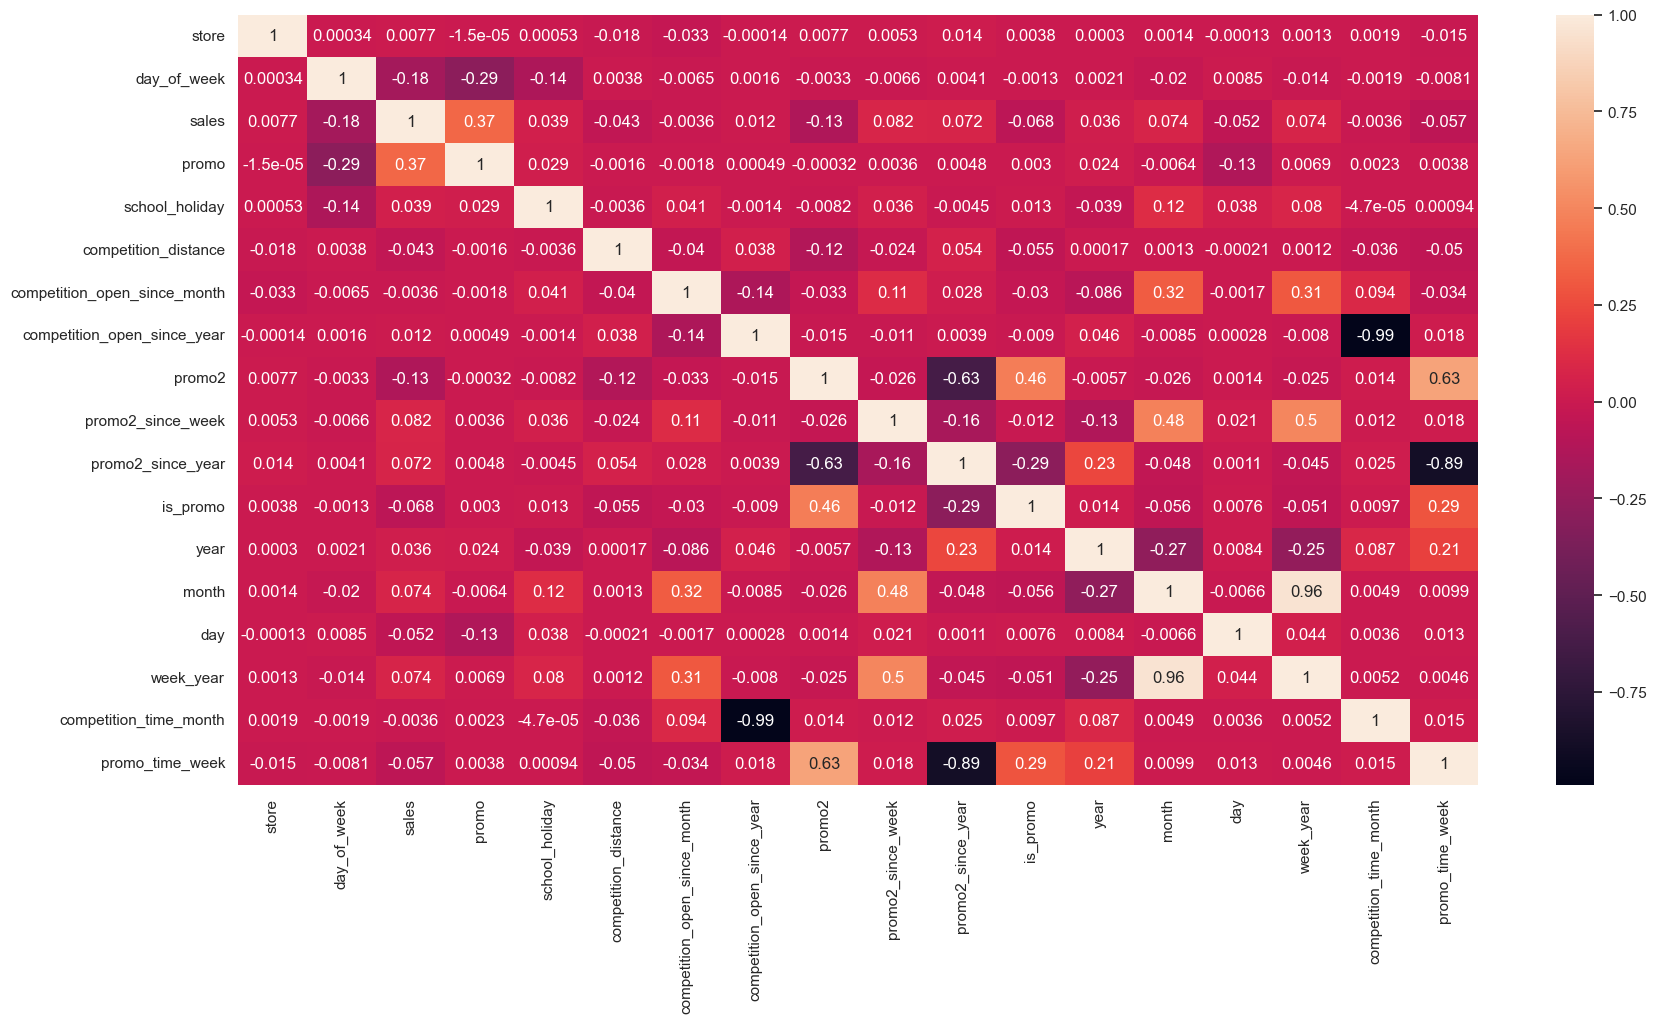

In [50]:
corr_num = num_attributes.corr(method = 'pearson')
sns.heatmap(corr_num, annot = True);

### Variáveis categóricas

Para verificar a associação entre as colunas categóricas vamos utilizar o coeficiente V de Cramer com correção (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), que pode ser aplicado em situações onde a informação se encontra distribuída por categorias nominais. O coeficiente tem valores entre 0 e 1, quanto mais próximo de 1 maior a correlação.

In [51]:
cat_attributes = df4.drop(['assortment', 'year_and_week'], axis =1).select_dtypes('object')

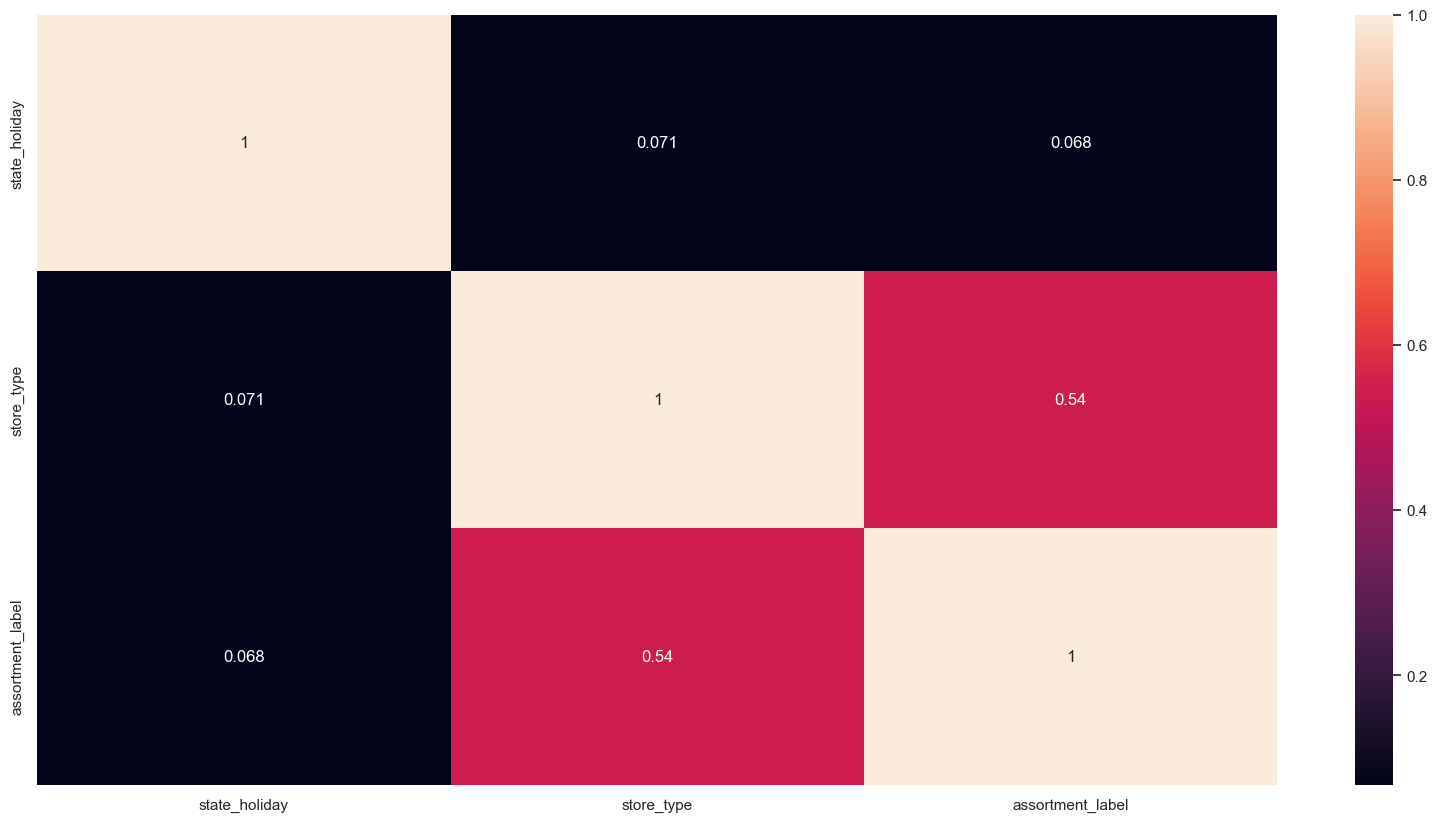

In [52]:
rows= []

for column in cat_attributes.columns:
    col = []
    
    for column2 in cat_attributes.columns:
        if column == column2:
            cramer = 1.0
        else:
            cramer =  corr_matrix(cat_attributes,[column,column2]).values[0][1]
        col.append(round(cramer, 4))
        
    rows.append(col)
     
cramer_results = np.array(rows)

df_cramer = pd.DataFrame(cramer_results, columns = cat_attributes.columns, index =cat_attributes.columns)
sns.heatmap(df_cramer,annot = True) ; 

# Preparação dos Dados

In [53]:
df5 = df4.copy()

## Rescaling

As variáveis numéricas não possuem uma distribuição normal, então para transformar estes dados vamos utilizar técnicas de rescaling, Min-Max Scaler (Normalização) para variáveis que não são afetadas por outliers e o Robust Scaler para as que possuem outliers relevantes:  
<center><b>Min-Max Scaler:</b></center></br>
$$
X_n = \frac{X_i + X_min}{X_max - X_min)}\\ \\    
$$</br>
$$
\mu = média\\
$$
<center><b>Robust Scaler</b></center></br>
$$
X_n = \frac{X_i + Q_1(X)}{Q_3(X) - Q_1(X)}
$$ </br>
$$
Q_1(X) = 1º Quartil\\
Q_3(X) = 3º Quartil
$$

In [54]:
rc = RobustScaler()
df5['competition_distance'] = rc.fit_transform(df5[['competition_distance']].values)
df5['competition_time_month'] = rc.fit_transform(df5[['competition_time_month']].values)

mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['year'] = mms.fit_transform(df5[['year']].values)

## Transformação

### Encoding

In [55]:
# One Hot Enconding state_holiday
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe_state_holiday = ohe.fit_transform(df5[['state_holiday']].values.reshape(-1,1)).toarray()

for i, column in enumerate(ohe.get_feature_names_out()):
    df5[column] = ohe_state_holiday[:,i]
    

# Label Enconder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Ordinal Encoder
assortment_dict = {'basic': 1, 'extra': 2, 'extend': 3}
df5['assortment'] = df5['assortment_label'].map(assortment_dict)

### Transformação da variável resposta

In [56]:
# transformação logarítma
df5['sales'] = np.log1p(df5['sales'])

### Transformação de Natureza

As variáveis restantes são variáveis de tempo e que denotam um ciclo, para realizar as transformações vamos se basear no círculo trigonométrico, onde cada valor(dia da semana ou mês, por exemplo) será representada por duas novas features com as medidas de seno e outra cosseno, como explica a imagem:

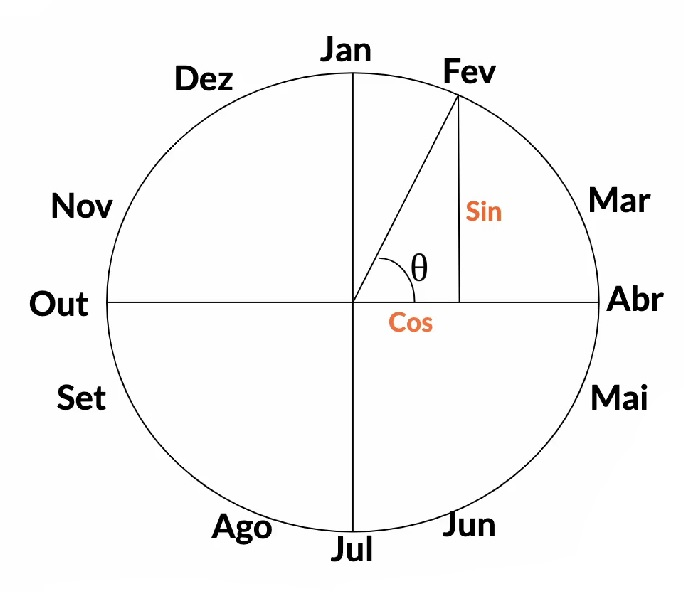

In [57]:
Image('images/ciclo_mes.jpg')

In [58]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))                                 
                                      
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 )))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 )))                                 

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))

#week_year
df5['week_year_sin'] = df5['week_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 )))
df5['week_year_cos'] = df5['week_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 )))


# Seleção de variáveis

In [59]:
df6 = df5.copy()

## Divisão treino e teste

In [60]:
df6.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_year,year_and_week,competition_since,competition_time_month,promo_since,promo_time_week,assortment_label,x0_christmas,x0_easter_holiday,x0_public_holiday,x0_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_year_sin,week_year_cos
0,1,5,2015-07-31,8.568646,1,regular_day,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,basic,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,regular_day,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,basic,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,regular_day,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,basic,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,regular_day,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,extend,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,regular_day,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,basic,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984


In [61]:
cols_drop = ['week_year', 'day', 'month', 'day_of_week', 'promo_since', 
             'competition_since', 'year_and_week', 'state_holiday', 'assortment_label']

df6 = df6.drop(cols_drop, axis = 1)

In [62]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,x0_christmas,x0_easter_holiday,x0_public_holiday,x0_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_year_sin,week_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0.0,0.0,0.0,1.0,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984


Todas as lojas possuem a mesma data inicial e final de vendas neste dataset, como o modelo preditivo tem um objetivo temporal, vamos separar para o teste as últimas 6 semanas de venda. A última data de vendas é 2015-07-31 assim, a última data para treino será 2015-06-18

In [63]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Treino:','\n','shape: X-->',X_train.shape, 'y-->',y_train.shape)
print('Data min:', X_train['date'].min())
print('Data max:', X_train['date'].max(), '\n')

print('Teste:','\n','shape: X-->',X_test.shape, 'y-->',y_test.shape)
print('Data min:', X_test['date'].min())
print('Data max:', X_test['date'].max())



Treino: 
 shape: X--> (802942, 29) y--> (802942,)
Data min: 2013-01-01 00:00:00
Data max: 2015-06-18 00:00:00 

Teste: 
 shape: X--> (41396, 29) y--> (41396,)
Data min: 2015-06-19 00:00:00
Data max: 2015-07-31 00:00:00


## Boruta para seleção de variáveis

In [64]:
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values
# random forest regressor
rf = RandomForestRegressor(n_jobs = 1)

boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2,random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [84]:
#cols_sel = boruta.support_.tolist()
cols_sel = [True,True,False, True, True, True, True, True, True, True, True, False, False, True,
 True, False, False, False, False, False, True, True, True, True, True, False, True]

# melhores features
cols_boruta = X_train.drop(['date', 'sales'], axis = 1).iloc[:,cols_sel].columns.to_list()


# features não selecionadas
cols_n_sel = list(np.setdiff1d(X_train_fs.columns, cols_boruta))

# colunas selecionadas
cols_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_year_cos']

In [83]:
# colunas não selecionadas 
cols_n_sel

['is_promo',
 'month_sin',
 'school_holiday',
 'week_year_sin',
 'x0_christmas',
 'x0_easter_holiday',
 'x0_public_holiday',
 'x0_regular_day',
 'year']

Das features não selecionadas pelo Boruta vamos manter para o modelo as variáveis month_sin e week_year_sin, são variáveis cíclicas que pela intuição da análise exploratória e hipóteses podem ser relevantes, e,  as outras variáveis que complementam o 'ciclo' foram selecionadas pelo boruta(month_cos e week_year_cos).

In [87]:
cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 
'month_cos', 'month_sin','day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 'week_year_cos', 'week_year_sin', 'date', 'sales']